In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir("/content/drive/MyDrive/data")

['Healthy', 'Blight', 'Common_Rust', 'Gray_Leaf_Spot']

In [ ]:
!unzip /content/drive/MyDrive/data.zip

In [ ]:
import os

data_dir = "/content/drive/MyDrive/data"

total_count = 0

for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        files_count = len(os.listdir(folder_path))
        print(f"Folder '{folder_name}' contains {files_count} images.")
        total_count += files_count

print(f"\nTotal number of images: {total_count}")


Folder 'Common_Rust' contains 1306 images.
Folder 'Blight' contains 1146 images.
Folder 'Gray_Leaf_Spot' contains 574 images.
Folder 'Healthy' contains 1162 images.

Total number of images: 4188


In [ ]:
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Specify paths for data directories
data_dir = "/content/drive/MyDrive/data"
train_dir = "/content/drive/MyDrive/train_data"
val_dir = "/content/drive/MyDrive/val_data"

batch_size=32

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Check if training and validation directories already contain data
train_data_exists = len(os.listdir(train_dir)) > 0
val_data_exists = len(os.listdir(val_dir)) > 0

if not (train_data_exists and val_data_exists):
    # Lists to store file paths and corresponding labels
    file_paths = []
    labels = []

    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                file_paths.append(os.path.join(folder_path, file_name))
                labels.append(folder_name)

    # Splitting data into training and validation sets
    train_files, val_files, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)
    # Print the number of samples in each set
    print(f"Number of training samples: {len(train_files)}")
    print(f"Number of validation samples: {len(val_files)}")

    image_file_path = file_paths[2]

    # Read the image using cv2
    image = cv2.imread(image_file_path)

    # Get the size of the image using the shape attribute
    height, width, channels = image.shape
    print(f"Image '{os.path.basename(image_file_path)}' size: {width} x {height} x {channels} pixels")

    # Moving files to train directory if it's empty
    if not train_data_exists:
        for file, label in zip(train_files, train_labels):
            os.makedirs(os.path.join(train_dir, label), exist_ok=True)
            os.rename(file, os.path.join(train_dir, label, os.path.basename(file)))

    # Moving files to validation directory if it's empty
    if not val_data_exists:
        for file, label in zip(val_files, val_labels):
            os.makedirs(os.path.join(val_dir, label), exist_ok=True)
            os.rename(file, os.path.join(val_dir, label, os.path.basename(file)))

Number of training samples: 3350
Number of validation samples: 838
Image 'Corn_Health (286).jpg' size: 256 x 256 x 3 pixels


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = "/content/drive/MyDrive/train_data"
val_dir = "/content/drive/MyDrive/val_data"
batch_size=32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # only normalization for validation data

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches of 32 using val_datagen generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3350 images belonging to 4 classes.
Found 838 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import os

# Number of classes
nb_classes = 4

# Define the optimizer
opt = Adam(learning_rate=0.001)

# Initialize the model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 classes, so the output layer has 4 neurons with softmax activation

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Define a checkpoint callback
checkpoint_path = "model_checkpoint_cornplantdisease.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[checkpoint],
                    verbose=1)


# Save the entire model to Google Drive
model.save("/content/drive/My Drive/model_checkpoint_cornplantdisease.weights.h5")
print("Model saved successfully in Google Drive.")

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(train_generator)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)

# Print training loss and accuracy
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)

# Print validation loss and accuracy
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 0.8088 - accuracy: 0.6639
Epoch 1: val_accuracy improved from -inf to 0.81026, saving model to model_checkpoint_cornplantdisease.keras
105/105 [==============================] - 76s 693ms/step - loss: 0.8088 - accuracy: 0.6639 - val_loss: 0.4817 - val_accuracy: 0.8103
Epoch 2/10
105/105 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.8024
Epoch 2: val_accuracy improved from 0.81026 to 0.83532, saving model to model_checkpoint_cornplantdisease.keras
105/105 [==============================] - 74s 707ms/step - loss: 0.5098 - accuracy: 0.8024 - val_loss: 0.3761 - val_accuracy: 0.8353
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.8131
Epoch 3: val_accuracy did not improve from 0.83532
105/105 [==============================] - 73s 700ms/step - loss: 0.4604 - accuracy: 0.8131 - val_loss: 0.3603 - val_accuracy: 0.8258
Epoch 4/10
105/105 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully in Google Drive.
27/27 [==============================] - 5s 185ms/step - loss: 0.3097 - accuracy: 0.8819
Training Loss: 0.3587118089199066
Training Accuracy: 0.8525373339653015
Validation Loss: 0.3097410500049591
Validation Accuracy: 0.8818615674972534


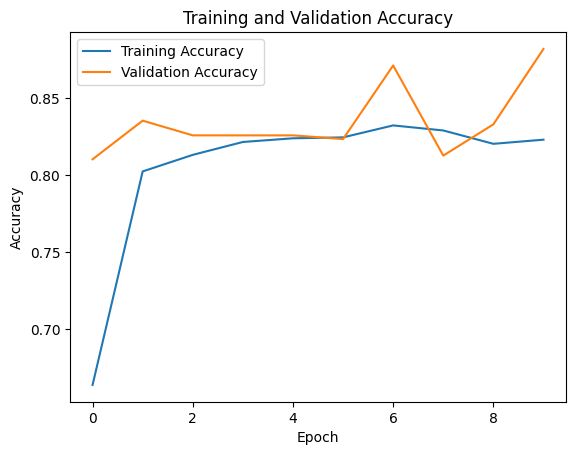

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

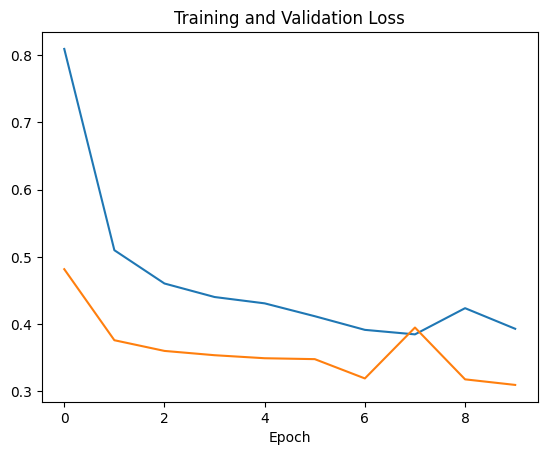

In [ ]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
# Generate predictions for the validation set
val_predictions = model.predict(val_generator)
val_pred_labels = np.argmax(val_predictions, axis=1)

# Get true labels for the validation set
val_true_labels = val_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Compute classification report
class_report = classification_report(val_true_labels, val_pred_labels,target_names=val_generator.class_indices.keys())

# Compute accuracy
accuracy = accuracy_score(val_true_labels, val_pred_labels)

# Compute F1 score
f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

# Compute precision
precision = precision_score(val_true_labels, val_pred_labels, average='weighted')

# Compute recall
recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
true_ordinal_labels = val_generator.labels
predicted_ordinal_labels = val_pred_labels  # Assuming predicted classes correspond to ordinal labels

# Calculate Pearson correlation coefficient
pearson_corr_coef = np.corrcoef(true_ordinal_labels, predicted_ordinal_labels)[0, 1]

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nAccuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Pearson Correlation Coefficient:", pearson_corr_coef)

27/27 [==============================] - 8s 273ms/step
Confusion Matrix:
[[198   0  24   1]
 [ 13 212   2   1]
 [ 55   1  70   1]
 [  1   0   0 259]]

Classification Report:
                precision    recall  f1-score   support

        Blight       0.74      0.89      0.81       223
   Common_Rust       1.00      0.93      0.96       228
Gray_Leaf_Spot       0.73      0.55      0.63       127
       Healthy       0.99      1.00      0.99       260

      accuracy                           0.88       838
     macro avg       0.86      0.84      0.85       838
  weighted avg       0.89      0.88      0.88       838


Accuracy: 0.8818615751789977
F1 Score: 0.8796776814514223
Precision: 0.8853549300855228
Recall: 0.8818615751789977
Pearson Correlation Coefficient: 0.8573869274526854


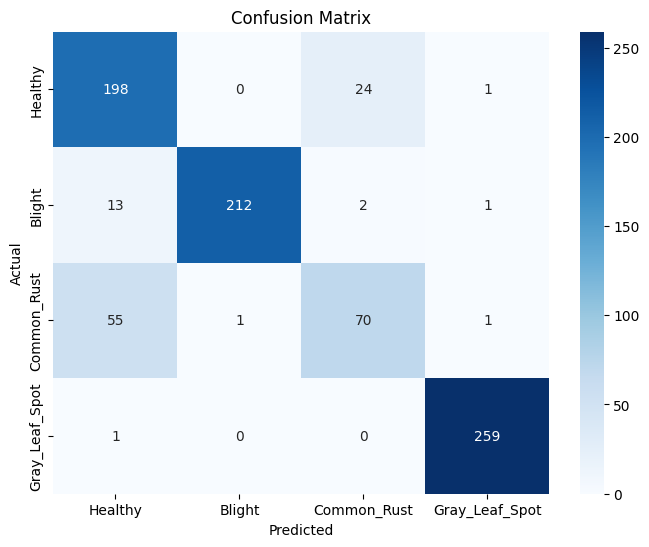

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Healthy', 'Blight', 'Common_Rust','Gray_Leaf_Spot'],
            yticklabels=['Healthy', 'Blight', 'Common_Rust','Gray_Leaf_Spot'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict classes for validation data
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes

# Compute evaluation metrics
accuracy = np.mean(predicted_classes == true_classes)
report = classification_report(true_classes, predicted_classes, target_names=val_generator.class_indices.keys())
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Compute correlation metrics
# Assuming your classes are ordinal, and you have ground truth ordinal labels
# Let's say true ordinal labels are in val_generator.labels
true_ordinal_labels = val_generator.labels
predicted_ordinal_labels = predicted_classes  # Assuming predicted classes correspond to ordinal labels

# Calculate Pearson correlation coefficient
pearson_corr_coef = np.corrcoef(true_ordinal_labels, predicted_ordinal_labels)[0, 1]

# Print evaluation metrics
print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print("Pearson Correlation Coefficient:", pearson_corr_coef)


27/27 [==============================] - 5s 165ms/step
Evaluation Metrics:
Accuracy: 0.8818615751789977
Classification Report:
                 precision    recall  f1-score   support

        Blight       0.74      0.89      0.81       223
   Common_Rust       1.00      0.93      0.96       228
Gray_Leaf_Spot       0.73      0.55      0.63       127
       Healthy       0.99      1.00      0.99       260

      accuracy                           0.88       838
     macro avg       0.86      0.84      0.85       838
  weighted avg       0.89      0.88      0.88       838

Confusion Matrix:
 [[198   0  24   1]
 [ 13 212   2   1]
 [ 55   1  70   1]
 [  1   0   0 259]]
Pearson Correlation Coefficient: 0.8573869274526854
